In [1]:
import sys
import pandas as pd
import numpy as np
import sklearn as sk
import tensorflow as tf
import tensorflow.keras
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tensorflow.keras.__version__}")
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # ignore tensorflow warnings

TensorFlow version: 2.1.0
Keras version: 2.2.4-tf
Python 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
Pandas 1.1.1
Scikit-Learn 0.23.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Retrieve data

In [2]:
train = pd.read_json('train.json', lines=True)
test = pd.read_json('test.json', lines=True)
public = test.query('seq_length == 107').copy()
private = test.query('seq_length == 130').copy()
print(train.shape)
print(public.shape)
print(private.shape)
train.head()

(2400, 19)
(629, 7)
(3005, 7)


,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


## Data processing

In [3]:
def process_seq(data, seq_length):
    # processes the 3 sequences and the target
    seq = data.loc[:, 'sequence'].str.slice(0, seq_length).values
    struct = data.loc[:, 'structure'].str.slice(0, seq_length).values
    loop = data.loc[:, 'predicted_loop_type'].str.slice(0, seq_length).values
    
    n = data.shape[0]

    new_seq = []
    new_struct = []
    new_loop = []

    for i in range(n):
        # sequence processing
        seq_dic = {'A': 0, 'C': 1, 'G': 2, 'U': 3} 
        n_seq = [seq_dic[l] for l in seq[i]]
        new_seq.append(n_seq)

        # structure processing
        struct_dic = {'(': 4, '.': 5, ')': 6}
        n_struct = [struct_dic[l] for l in struct[i]]
        new_struct.append(n_struct)

        # predicted_loop_type processing
        loop_dic = {'S':7, 'M':8, 'I':9, 'B':10, 'H':11, 'E':12, 'X':13}
        n_loop = [loop_dic[l] for l in loop[i]]
        new_loop.append(n_loop)
        
    new_seq = np.array(new_seq)
    new_struct = np.array(new_struct)
    new_loop = np.array(new_loop)
        
    new_seq = new_seq.reshape(new_seq.shape[0], new_seq.shape[1], 1) 
    new_struct = new_struct.reshape(new_struct.shape[0], new_struct.shape[1], 1)
    new_loop = new_loop.reshape(new_loop.shape[0], new_loop.shape[1], 1)
    
    return np.concatenate([new_seq, new_struct, new_loop], axis=2)

def process_target(data, seq_scored):
    n = data.shape[0]
    y_train = data.loc[:, ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']]
    new_target = np.zeros((n, 5, seq_scored))
    
    for i in range(n):
        new_target[i, :, :] = np.concatenate(y_train.values[i]).reshape(5, seq_scored)
    # swap the 2 last axes to match sequence shape
    new_target = np.swapaxes(new_target, 1, 2)
    return new_target

In [4]:
features = process_seq(train, seq_length=107)
features_public = process_seq(public, seq_length=107)
features_private = process_seq(private, seq_length=130)

target = process_target(train, seq_scored=68)

print(features.shape)
print(features_public.shape)
print(features_private.shape)
print(target.shape)
# features of the first 4 bases of the first sequence
print(features[0, :4, :])

(2400, 107, 3)
(629, 107, 3)
(3005, 130, 3)
(2400, 68, 5)
[[ 2  5 12]
 [ 2  5 12]
 [ 0  5 12]
 [ 0  5 12]]


## New features

#### We are going to add some features with the bpps files

In [5]:
def get_bpps(ids):
    # retrieve bpps matrices
    bpps = []
    for id in tqdm(ids):
        bpps.append(np.load(f"bpps/{id}.npy"),)
    return np.array(bpps)


X_bpps = get_bpps(train.id.values)
X_bpps_public = get_bpps(public.id.values)
X_bpps_private = get_bpps(private.id.values)
print(X_bpps.shape)
print(X_bpps_public.shape)
print(X_bpps_private.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 3005/3005 [00:15<00:00, 194.52it/s]

(2400, 107, 107)
(629, 107, 107)
(3005, 130, 130)


In [6]:
def min_max_norm(m):
    # min max scaling for non negatives values
    maxi = np.amax(m) + 1e-8  # avoid dividing by 0
    return m / maxi


def get_nonzeros(X_bpps):
    # return non 0 proportion of each row of the bpps files
    X_bpps_nonzeros_prop = []
    n = X_bpps.shape[0]
    seq_length = X_bpps.shape[1]
    for k in range(n):
        X_bpps_nonzeros_prop.append(1 - ((X_bpps[k] == 0).sum(axis=1) / seq_length))
    X_bpps_nonzeros_prop = np.array(X_bpps_nonzeros_prop)
    return X_bpps_nonzeros_prop


def get_dist(sequences, structures, seq_length):
    # return new sequence corresponding to the associated paires of sequences
    # return distance matrix according to the distance between paired bases
    dist = np.zeros((structures.shape[0], seq_length, seq_length))
    idx = []
    pair_base = np.zeros((structures.shape[0], seq_length))
    for row, structure in tqdm(enumerate(structures)):
        for i, token in enumerate(structure):
            if token == "(":
                idx.append(i)
            elif token == ")":
                j = idx.pop()  # index of the corresponding '(' 
                dist[row, i, j] = i-j
                dist[row, j, i] = i-j
                pair_base[row, j] = sequences[row, i] + 15
                pair_base[row, i] = sequences[row, j] + 15
    pair_base[np.where(pair_base == 0)] = 14
    return pair_base.reshape(structures.shape[0], seq_length, 1), dist


def get_features(sequences, data, seq_length):
    # return the stats features from bpps files
    X_bpps = get_bpps(data.id.values)  # retrieve bpps matrices
    X_pair, X_dist = get_dist(sequences, data['structure'].str.slice(0, seq_length), seq_length)
    X_bpps_nonzeros_prop = get_nonzeros(X_bpps)

    train_bpps_stats = [min_max_norm(X_bpps.sum(axis=2)),  # mean of non zeros values for each base
                        min_max_norm(X_bpps.max(axis=2)),  # max value for each base
                        min_max_norm(X_bpps_nonzeros_prop),  # proportion of non zeros for each base
                        min_max_norm(X_dist.sum(axis=2))]  # distance of the base to its partner 
    X_stats = np.concatenate([stats[:,:,None] for stats in train_bpps_stats], axis=2)
    return X_pair, X_stats, X_bpps, X_dist

# bpps stats features
X_pair, X_stats, X_bpps, X_dist = get_features(features[:, :, 0], train, seq_length=107)
X_pair_public, X_stats_public, X_bpps_public, X_dist_public = get_features(features_public[:, :, 0], public, seq_length=107)
X_pair_private, X_stats_private, X_bpps_private, X_dist_private = get_features(features_private[:, :, 0], private, seq_length=130)

# concatenate sequences features and bpps stats features
X = np.concatenate([features, X_pair, X_stats], axis=2)
np.save('X.npy', X)
X_public = np.concatenate([features_public, X_pair_public, X_stats_public], axis=2)
np.save('X_public.npy', X_public)
X_private = np.concatenate([features_private, X_pair_private, X_stats_private], axis=2)
np.save('X_private.npy', X_private)
y = target
np.save('y.npy', y)

100%|████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:00<00:00, 3235.17it/s]
2400it [00:00, 18267.48it/s]
100%|██████████████████████████████████████████████████████████████████████████████| 629/629 [00:00<00:00, 3272.82it/s]
629it [00:00, 13897.13it/s]
100%|████████████████████████████████████████████████████████████████████████████| 3005/3005 [00:00<00:00, 3147.68it/s]
3005it [00:00, 11832.02it/s]


In [7]:
# split data
# lets select validation indexes where SN_filter = 1. 
# Indeed private test sequences are based on that type of filter
np.random.seed(42)
idx_filter = np.where(train.SN_filter == 1)[0]
choice = np.random.choice(idx_filter, 256, replace=False)
idx_valid = np.ones(X.shape[0], dtype=np.bool)
idx_valid[choice] = False

X_train = X[idx_valid, :, :]
X_valid = X[~idx_valid, :, :]
y_train = y[idx_valid]
y_valid = y[~idx_valid]

# add importance to each observation
weights = np.array(np.log(train.signal_to_noise + 1.05)/2) 
train_weight = weights[idx_valid]

print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)
print(X_public.shape)
print(X_private.shape)
print(X_train[0, :7, :4])  # stats for the first 4 bases of the 4 sequence
print(X_train[0, :7, 4:])  # stats for the first 4 bases of the 4 stats
print(train_weight.shape)

(2144, 107, 8)
(256, 107, 8)
(2144, 68, 5)
(256, 68, 5)
(629, 107, 8)
(3005, 130, 8)
[[ 2.  5. 12. 14.]
 [ 2.  5. 12. 14.]
 [ 0.  5. 12. 14.]
 [ 0.  5. 12. 14.]
 [ 0.  5. 12. 14.]
 [ 0.  4.  7. 18.]
 [ 2.  4.  7. 16.]]
[[0.19854398 0.02178589 0.31818181 0.        ]
 [0.18371376 0.03865303 0.22727272 0.        ]
 [0.06000291 0.02759063 0.05681818 0.        ]
 [0.01312232 0.00947074 0.04545454 0.        ]
 [0.01127996 0.00702879 0.03409091 0.        ]
 [0.12739688 0.0698996  0.06818182 0.24050633]
 [0.35076808 0.11479298 0.22727272 0.21518987]]
(2144,)


## Build model

In [10]:
def ResConv1D(x, units, kernel_size=3):
    # Convolution block with skip connections
    x = Conv1D(units, kernel_size, strides=1, padding='same', 
               kernel_initializer='glorot_normal', activation=None)(x)
    x = LayerNormalization()(x)
    x = LeakyReLU()(x)
    
    x1 = Conv1D(units, kernel_size, strides=1, padding='same', 
                kernel_initializer='glorot_normal', activation=None)(x)
    x1 = LayerNormalization()(x1)
    x1 = LeakyReLU()(x1)
    
    res = Add()([x, x1])
    return res

In [11]:
def build_model(input_seq=4, input_stats=4, seq_length=107, seq_scored=68):
    input_seq = Input((seq_length, input_seq))
    input_stats = Input((seq_length, input_stats))
    
    # Embedding layer only for the 3 sequences
    
    emb = Embedding(input_dim=19, input_length=seq_length, output_dim=100)(input_seq)
    # reshape to match the shape of the input
    reshaped = tf.reshape(emb, shape=(-1, emb.shape[1], emb.shape[2]*emb.shape[3]))
    # concat embedded sequences and bpps stats
    x = concatenate([reshaped, input_stats])

    x = LayerNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    
    # Convolutional block with skip connections
    x0 = ResConv1D(x, 512, kernel_size=3)
    x1 = ResConv1D(x0, 256, kernel_size=5)
    x2 = ResConv1D(x1, 128, kernel_size=7)
    x3 = ResConv1D(x2, 64, kernel_size=15)
    x4 = ResConv1D(x3, 32, kernel_size=30)
    x = Concatenate()([x0, x1, x2, x3, x4])
    
    x = Bidirectional(LSTM(units=512, 
                         activation='tanh',
                         kernel_initializer='orthogonal',
                         dropout=0.5,
                         return_sequences=True))(x)
    x = Bidirectional(LSTM(units=512, 
                         activation='tanh',
                         kernel_initializer='orthogonal',
                         dropout=0.5,
                         return_sequences=True))(x)

    # we need only the first seq_scored bases
    x = x[:, :seq_scored]
    
    output = Dense(5, activation=None)(x)
    model = Model(inputs=[input_seq, input_stats], outputs=output)
    
    opt = optimizers.Adam(lr=0.001)
    
    # we use the loss that is used for the evaluation according to the rules
    def mcrmse(y_true, y_pred):
        # Mean Columnwise Root Mean Squared Error
        #weights = tf.constant(np.array([0.3, 0.3, 0.05, 0.3, 0.05], dtype=np.float32))
        colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
        #res = tf.reduce_mean(tf.math.multiply(tf.sqrt(colwise_mse), weights), axis=1)
        res = tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)
        return res

    model.compile(loss=mcrmse, optimizer=opt)
    
    return model

In [12]:
def train_model(model, X_train, X_valid, y_train, y_valid, train_weight, n_epoch=200, batch_size=128, verbose=1):
    checkpoint_filepath = 'MyCheckpoint'
    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                 monitor='val_loss',
                                 mode='min',
                                 save_weights_only=True,
                                 save_best_only=True)
    reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                             factor=0.3,
                                                             patience=10,
                                                             min_lr=1.001e-4,
                                                             verbose=1)
    early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                              patience=14, 
                                                              mode='auto',
                                                              baseline=None,
                                                              restore_best_weights=True,
                                                              verbose=0)
    callback = [checkpoint, reduce_lr, early_stopping]
        
    
    X_train_seq = X_train[:, :, :4]
    X_train_stats = X_train[:, :, 4:]
        
    X_valid_seq = X_valid[:, :, :4]
    X_valid_stats = X_valid[:, :, 4:]
    validation_data = ([X_valid_seq, X_valid_stats], y_valid)
    
    history = model.fit([X_train_seq, X_train_stats], y_train, sample_weight=train_weight, validation_data=validation_data, 
                        epochs=n_epoch, batch_size=batch_size, verbose=verbose, callbacks=callback)
    return model, history

## Train model

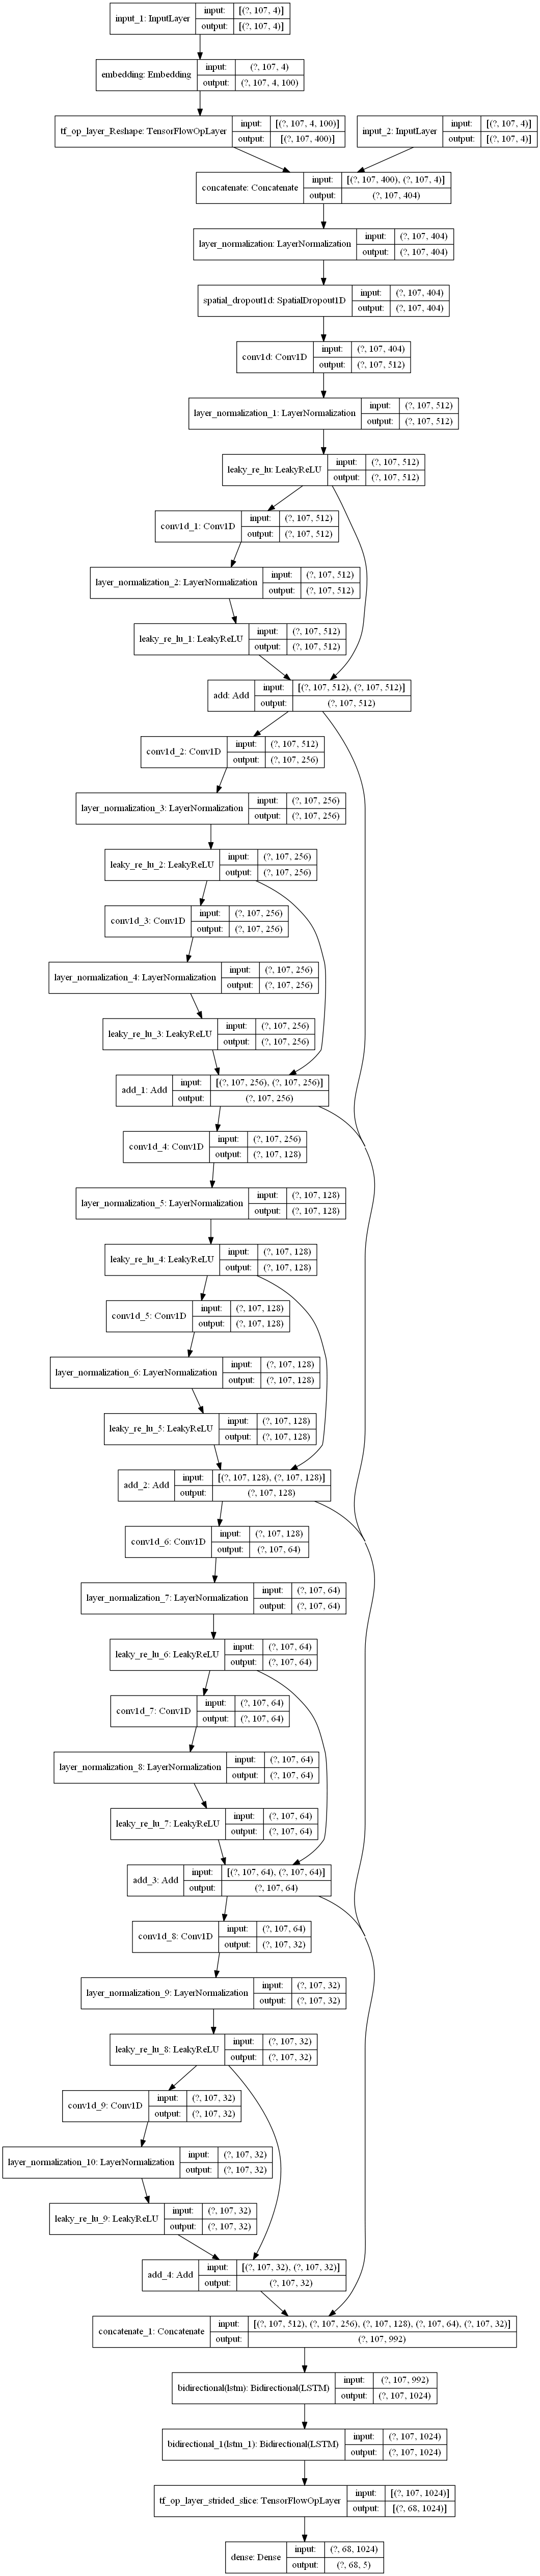

In [13]:
clear_session()
model = build_model(input_seq=4, input_stats=4, seq_length=107, seq_scored=68)
plot_model(model, to_file='model.png', show_shapes=True)

In [14]:
model, history = train_model(model, X_train, X_valid, y_train, y_valid, train_weight, n_epoch=250, batch_size=32, verbose=1)

Train on 2144 samples, validate on 256 samples
Epoch 1/250
2144/2144 [==============================] - 17s 8ms/sample - loss: 0.4143 - val_loss: 0.3445
Epoch 2/250
2144/2144 [==============================] - 9s 4ms/sample - loss: 0.2755 - val_loss: 0.3115
Epoch 3/250
2144/2144 [==============================] - 9s 4ms/sample - loss: 0.2561 - val_loss: 0.2924
Epoch 4/250
2144/2144 [==============================] - 9s 4ms/sample - loss: 0.2409 - val_loss: 0.2681
Epoch 5/250
2144/2144 [==============================] - 9s 4ms/sample - loss: 0.2319 - val_loss: 0.2657
Epoch 6/250
2144/2144 [==============================] - 9s 4ms/sample - loss: 0.2241 - val_loss: 0.2515
Epoch 7/250
2144/2144 [==============================] - 9s 4ms/sample - loss: 0.2174 - val_loss: 0.2489
Epoch 8/250
2144/2144 [==============================] - 9s 4ms/sample - loss: 0.2123 - val_loss: 0.2446
Epoch 9/250
2144/2144 [==============================] - 9s 4ms/sample - loss: 0.2066 - val_loss: 0.2394
Epoch 1

Epoch 77/250
2144/2144 [==============================] - 7s 3ms/sample - loss: 0.1150 - val_loss: 0.1947
Epoch 78/250
2144/2144 [==============================] - 9s 4ms/sample - loss: 0.1131 - val_loss: 0.1939
Epoch 79/250
2144/2144 [==============================] - 9s 4ms/sample - loss: 0.1122 - val_loss: 0.1930
Epoch 80/250
2144/2144 [==============================] - 9s 4ms/sample - loss: 0.1115 - val_loss: 0.1930
Epoch 81/250
2144/2144 [==============================] - 7s 3ms/sample - loss: 0.1110 - val_loss: 0.1932
Epoch 82/250
2144/2144 [==============================] - 7s 3ms/sample - loss: 0.1104 - val_loss: 0.1932
Epoch 83/250
2144/2144 [==============================] - 7s 3ms/sample - loss: 0.1100 - val_loss: 0.1930
Epoch 84/250
2144/2144 [==============================] - 9s 4ms/sample - loss: 0.1097 - val_loss: 0.1926
Epoch 85/250
2144/2144 [==============================] - 7s 3ms/sample - loss: 0.1096 - val_loss: 0.1931
Epoch 86/250
2144/2144 [======================

256/256 [==============================] - 0s 1ms/sample - loss: 0.1926
Loss valid: 0.192611675709486


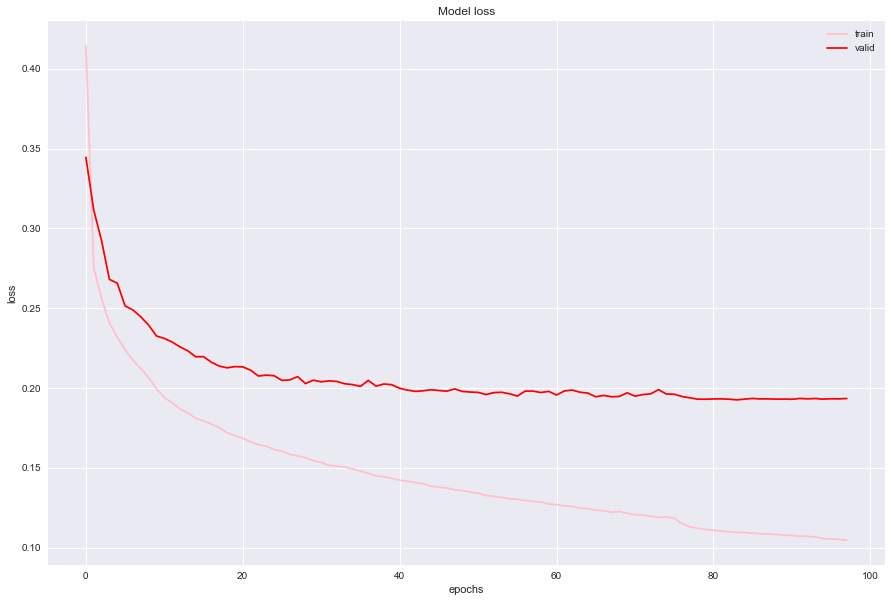

In [15]:
model.load_weights('MyCheckpoint')  # load best model
plot_model(model, to_file='model.png', show_shapes=True)
loss_valid = model.evaluate([X_valid[:, :, :4], X_valid[:, :, 4:]], y_valid)  # rmse 0.216
print('Loss valid: {}'.format(loss_valid))  
# 0.1926 256v x5 3-30


def plot_history(history):
    plt.figure(figsize=(15, 10))
    plt.plot(history.history['loss'], color='pink', label='train')
    plt.plot(history.history['val_loss'], color='red', label='valid')
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show()

plot_history(history)

## Cross-Validation

In [16]:
def cv_model(train, X, X_public, X_private, y, weights, n_fold=5):
    # cross-validate model
    # to test if it works well with different portion of data
    # because we do not have a lot of data available
    # we will predict on each sample of Kfold and then average the result
    # as a result we would have a prediction that as been trained on all data
    # Kfold only on SN_filter = 1 (66% of train data)
    # return: mean of public preds, mean of private preds, losses of all folds
    n = X.shape[0]
    public_preds = []
    private_preds = []
    losses = []
    
    idx_filtered = np.where(train.SN_filter == 1)[0]
    fold_size = idx_filtered.shape[0] // n_fold
    
    for i in range(n_fold):
        choice = None
        if i == n_fold-1:
            choice = idx_filtered[i*fold_size:]
        else:
            choice = idx_filtered[i*fold_size:(i+1)*fold_size]
    
        idx = np.ones(n, dtype=np.bool)
        idx[choice] = False
        
        X_train, X_valid = X[idx], X[~idx]
        y_train, y_valid = y[idx], y[~idx]
        w_train = weights[idx]
        
        # build model
        clear_session()
        model = build_model(input_seq=4, input_stats=4, seq_length=107, seq_scored=68)
        model, history = train_model(model, X_train, X_valid, y_train, y_valid, w_train, n_epoch=250, batch_size=32, verbose=2)

        # train model
        model.load_weights('MyCheckpoint')  # load best model

        # evaluate model on validation
        loss_valid = model.evaluate([X_valid[:, :, :4], X_valid[:, :, 4:]], y_valid)
        losses.append(loss_valid)
        
        # make prediction for public and private
        model_public = build_model(input_seq=4, input_stats=4, seq_length=107, seq_scored=107)
        model_private = build_model(input_seq=4, input_stats=4, seq_length=130, seq_scored=130)
        
        model_public.load_weights('MyCheckpoint')
        pred_public = model_public.predict([X_public[:, :, :4], X_public[:, :, 4:]])
        public_preds.append(pred_public)

        model_private.load_weights('MyCheckpoint')
        pred_private = model_private.predict([X_private[:, :, :4], X_private[:, :, 4:]])
        private_preds.append(pred_private)
        print('Fold {} Done ...'.format(i+1))
    
    # get the mean of the predictions across all folds
    pred_public = np.array(public_preds).mean(axis=0)
    pred_public[pred_public < 0.0] = 0.0
    pred_public[pred_public > 6.0] = 6.0
    np.save('pred_public.npy', pred_public)

    pred_private = np.array(private_preds).mean(axis=0)
    pred_private[pred_private < 0.0] = 0.0
    pred_private[pred_private > 6.0] = 6.0
    np.save('pred_private.npy', pred_private)
    
    return pred_public, pred_private, losses

#pred_public, pred_private, losses = cv_model(train, X, X_public, X_private, y, weights, n_fold=5)
#print(losses)
#print(np.mean(losses))

## Prepare submission

In [17]:
# for the submission we need the full length so we set seq_scored to seq_length
model_public = build_model(input_seq=4, input_stats=4, seq_length=107, seq_scored=107)
model_private = build_model(input_seq=4, input_stats=4, seq_length=130, seq_scored=130)

In [18]:
model_public.load_weights('MyCheckpoint')
pred_public = model_public.predict([X_public[:, :, :4], X_public[:, :, 4:]])
pred_public[pred_public < 0.0] = 0.0
pred_public[pred_public > 6.0] = 6.0

model_private.load_weights('MyCheckpoint')
pred_private = model_private.predict([X_private[:, :, :4], X_private[:, :, 4:]])
pred_private[pred_private < 0.0] = 0.0
pred_private[pred_private > 6.0] = 6.0

In [19]:
def build_submission(public, private, pred_public, pred_private):
    preds = []
    for df, pred in [(public, pred_public), (private, pred_private)]:
        for i, uid in enumerate(df.id):
            single_pred = pred[i]
            single_df = pd.DataFrame(single_pred, columns=['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C'])
            single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
            preds.append(single_df)
    return pd.concat(preds).reset_index(drop=True)

sub = build_submission(public, private, pred_public, pred_private)
cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C', 'id_seqpos']
cols = cols[-1:] + cols[:-1]
sub = sub[cols]
sub.to_csv('MySubmission.csv', index=False)  # ready for submission
sub

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.780468,0.658093,1.858708,0.582977,0.818368
1,id_00073f8be_1,2.328752,3.615902,3.823226,3.567883,3.001400
2,id_00073f8be_2,1.884708,0.783456,0.506767,0.825822,0.685554
3,id_00073f8be_3,1.377604,1.172825,1.049757,1.647037,2.119433
4,id_00073f8be_4,0.763888,0.702521,0.443139,0.884068,0.960681
...,...,...,...,...,...,...
457948,id_ffda94f24_125,0.135469,0.291236,0.332294,0.426812,0.264978
457949,id_ffda94f24_126,0.176892,0.359875,0.594330,0.503442,0.513067
457950,id_ffda94f24_127,0.335411,0.112777,0.153011,0.148620,0.292851
457951,id_ffda94f24_128,0.179440,0.151667,0.027007,0.242244,0.117964
